# This notebook contains validation of Xenium-H&E registration

1. nuclei segmentation on H&E and DAPI (generated complementary to Xenium) using stardist
3. evluation using metrics normalized mutual information (NMI), dice coefficient and jaccard index

In [1]:
import sys, json, argparse
import numpy as np, pandas as pd
from scipy import ndimage
import rasterio, rasterio.features
from rasterio.transform import Affine

import tifffile as tiff
from csbdeep.utils import normalize
from stardist.models import StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
import csv

from pathlib import Path
import matplotlib.pyplot as plt

## 1. Stardist segmentation

In [10]:
identifier = "0060491"
sample = "661B"

# change pth here

#H&E
in_path   = Path("") 
# DAPI
#in_path   = Path("")

out_dir  = Path("")
out_dir.mkdir(parents=True, exist_ok=True) 

# change name here
out_file = out_dir / f"{sample}_stardist_seg_hae.tif" 

In [11]:
img = tiff.imread(in_path)                 # (Y, X[, C])
print(img.shape)

# if multi-layer DAPI, only keep the first layer (DAPI)
# hae skip

#img = img[0]         
#print(img.shape)

(34091, 51177, 3)


In [13]:
#normalize img to 0-1
img_norm = normalize(img)

print(img_norm.shape)       #(44267, 48318, 3) - 653B

(34091, 51177, 3)


In [14]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_he') # hae model
#model = StarDist2D.from_pretrained('2D_versatile_fluo') # dapi model

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 140/140 [12:24<00:00,  5.32s/it]


Text(0.5, 1.0, 'prediction + input overlay')

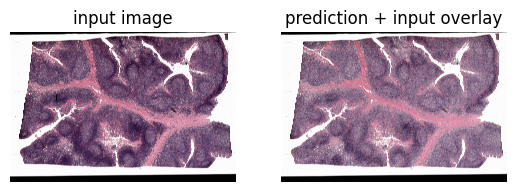

In [15]:
#labels, _ = model.predict_instances(normalize(img))

# hae
labels, details = model.predict_instances_big(
    img_norm, axes='YXC',
    block_size=4096,   #4096
    min_overlap=128,   #128 # ensures objects crossing tiles are merged well
    context=128         #128 # extra pixels around blocks for network context 64-96
)

# dapi
# labels, details = model.predict_instances_big(
#     img_norm, axes='YX', #YX - YXC
#     block_size=4096,
#     min_overlap=128,   
#     context=128        
# )


plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

In [ ]:
#save segmentation masks
tiff.imwrite(out_file, labels.astype(np.uint16), compression="lzw")
#print(f"prob={p}  nms={n}  → objects: {lbl.max()}")
print(f"Saved → {out_file}\nObjects detected: {labels.max()}")
print("prob_thresh:", model.thresholds.prob)
print("nms_thresh:", model.thresholds.nms)

## 2. Load segmentation mask and calculate similarity score

### global metrics: nmi, jaccard, dice

normalized mutual information: compares the partition of pixels into instances inside H&E cells

dice coefficient & jaccard index:pixel overlap only inside H&E cells. Because the evaluation domain is the H&E mask, these behave like recall of DAPI vs. H&E

In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import tifffile as tiff
from pathlib import Path

sample = "661B"
dapi_ct = 
hae_ct =  

out_dir  = Path("")

# ---------- IO ----------
def load_label_tiff(path: str | Path) -> np.ndarray:
    """
    Load a (O)ME-TIFF/BigTIFF of integer labels with 0 as background.
    Uses memmap when possible to avoid loading the entire image at once.
    Returns a NumPy array (may be a memmap).
    """
    path = Path(path)

    try:
        arr = tiff.memmap(path)
        return arr
    except Exception:
        return tiff.imread(path)

# ---------- Global Metrics ----------
def compute_similarity_metrics(
    labels_he: np.ndarray,
    labels_dapi: np.ndarray,
    ignore_label: int = 0,
    nmi_ignore_background: bool = True
):
    """
    Pixelwise NMI on instance IDs; Dice/Jaccard on binarized foreground.
    """
    if labels_he.shape != labels_dapi.shape:
        raise ValueError(f"Shape mismatch: HE {labels_he.shape}, DAPI {labels_dapi.shape}")

    # Ensure integer dtype (do not cast to float to avoid label changes)
    if not np.issubdtype(labels_he.dtype, np.integer):
        labels_he = labels_he.astype(np.int64, copy=False)
    if not np.issubdtype(labels_dapi.dtype, np.integer):
        labels_dapi = labels_dapi.astype(np.int64, copy=False)

    # --- NMI ---
    a = labels_he.ravel()
    b = labels_dapi.ravel()
    if nmi_ignore_background:
        mask = (a != ignore_label) | (b != ignore_label)  # any foreground
        if mask.any():
            nmi = normalized_mutual_info_score(a[mask], b[mask], average_method="arithmetic")
        else:
            nmi = np.nan
    else:
        nmi = normalized_mutual_info_score(a, b, average_method="arithmetic")

    # --- Dice / Jaccard (binary foreground vs background) ---
    A = (labels_he != ignore_label)
    B = (labels_dapi != ignore_label)
    # use 64-bit ints to avoid overflow
    intersection = np.int64((A & B).sum())
    a_sum = np.int64(A.sum())
    b_sum = np.int64(B.sum())
    union = a_sum + b_sum - intersection

    if a_sum == 0 and b_sum == 0:
        dice = 1.0
        jaccard = 1.0
    elif union == 0:
        dice = 0.0
        jaccard = 0.0
    else:
        dice = (2 * intersection) / (a_sum + b_sum)
        jaccard = intersection / union

    return {"nmi": float(nmi), "dice": float(dice), "jaccard": float(jaccard)}

# ---------- mask on H&E domain ----------
def _safe_hist2d(a, b, n_a=None, n_b=None):
    ua, ia = np.unique(a, return_inverse=True)
    ub, ib = np.unique(b, return_inverse=True)
    if n_a is None: n_a = ua.size
    if n_b is None: n_b = ub.size
    M = np.bincount(ia * n_b + ib, minlength=n_a * n_b).reshape(n_a, n_b)
    return M

def _entropy(counts):
    total = counts.sum()
    if total == 0:
        return 0.0
    p = counts[counts > 0] / total
    return float(-(p * np.log(p)).sum())

def nmi_numpy(a, b):
    M = _safe_hist2d(a, b)
    N = M.sum()
    if N == 0:
        return np.nan
    Ha = _entropy(M.sum(axis=1))
    Hb = _entropy(M.sum(axis=0))
    with np.errstate(divide='ignore', invalid='ignore'):
        Pij = M / N
        Pi = M.sum(axis=1, keepdims=True) / N
        Pj = M.sum(axis=0, keepdims=True) / N
        denom = Pi @ Pj
        mask = (Pij > 0) & (denom > 0)
        MI = float((Pij[mask] * np.log(Pij[mask] / denom[mask])).sum())
    denom_ent = (Ha + Hb) / 2.0
    return float(MI / denom_ent) if denom_ent > 0 else np.nan

def compare_he_vs_dapi(he, dapi, ignore_label=0):
    if he.shape != dapi.shape:
        raise ValueError(f"Shape mismatch: HE {he.shape}, DAPI {dapi.shape}")

    he = np.asarray(he)
    dapi = np.asarray(dapi)

    # Restrict evaluation to H&E foreground only
    roi = (he != ignore_label)
    if not roi.any():
        return {
            "dice_masked": np.nan,
            "jaccard_masked": np.nan,
            "nmi_masked": np.nan
        }

    he_roi = he[roi]
    dapi_roi = dapi[roi]

    # 2) Pixel-level masked Dice/Jaccard (within ROI = HE>0)
    tp = np.int64((dapi_roi != ignore_label).sum())   # DAPI foreground inside HE cells
    fn = np.int64((dapi_roi == ignore_label).sum())   # Missed by DAPI within HE cells
    A = tp + fn                                       # = number of HE-foreground pixels
    if A == 0:
        dice_masked = np.nan
        jaccard_masked = np.nan
    else:
        jaccard_masked = tp / (tp + fn)
        dice_masked = (2 * tp) / (2 * tp + fn)

    # 3) NMI within HE mask (label-permutation invariant)
    nmi_masked = nmi_numpy(he_roi, dapi_roi)

    return {
        "dice_masked": float(dice_masked),
        "jaccard_masked": float(jaccard_masked),
        "nmi_masked": float(nmi_masked)
    }


if __name__ == "__main__":
    he_path   = ""     # 0 = background, 1..K = cell IDs
    dapi_path = ""     # 0 = background, 1..K = cell IDs

    he = load_label_tiff(he_path)
    dapi = load_label_tiff(dapi_path)

    metrics_global = compute_similarity_metrics(he, dapi, ignore_label=0, nmi_ignore_background=True)
    masked = compare_he_vs_dapi(he, dapi, ignore_label=0)

    print(sample)
    print(metrics_global)
    for k, v in masked.items():
        print(f"{k}: {v}")